In [21]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
import pyqmc.api as pyq
from pyscf.scf.uhf import det_ovlp
import matplotlib.pyplot as plt

In [2]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvdz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 3,2)
    mc.fcisolver.nroots = 2
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc
    
def HF_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; F 0. 0. 0.8",
        basis=f"ccecpccpvdz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 6,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [3]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = H2_casci(scf_checkfile, ci_checkfile)
# mol, mf, mcc = HF_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [4]:
mcc.e_tot

array([-1.13870534, -0.7352647 ])

In [5]:
mc1 = copy.copy(mcc)
mc2 = copy.copy(mcc)

In [6]:
mcc.ci

[FCIvector([[ 9.96853209e-01, -8.46545056e-16,  5.80454666e-03],
            [-1.46467752e-15, -5.39115620e-02,  1.02970861e-15],
            [ 5.80454666e-03,  6.85996757e-16, -5.75311894e-02]]),
 FCIvector([[ 5.10247623e-16, -7.03065761e-01,  7.86737405e-16],
            [ 7.03065761e-01,  3.91040073e-16, -7.54886440e-02],
            [-2.94224039e-15,  7.54886440e-02,  1.95096737e-16]])]

In [7]:
mc1.ci = mcc.ci[0] * 0 
mc1.ci[0,0] = 1

mc2.ci = mcc.ci[0] * 0 
mc2.ci[1,1] = 1

In [8]:
mc1.ci

FCIvector([[ 1., -0.,  0.],
           [-0., -0.,  0.],
           [ 0.,  0., -0.]])

In [9]:
# mc1.ci = mcc.ci[0]
# mc2.ci = (mcc.ci[0] + mcc.ci[1]) / np.sqrt(2)

In [10]:
mc1.ci

FCIvector([[ 1., -0.,  0.],
           [-0., -0.,  0.],
           [ 0.,  0., -0.]])

In [11]:
wf1, _ = pyq.generate_slater(mol, mf, mc=mc1, optimize_determinants=True)
wf2, _ = pyq.generate_slater(mol, mf, mc=mc2, optimize_determinants=True)

In [12]:
configs = pyq.initial_guess(mol, 2000)
_, configs = pyq.vmc(wf1, configs)

In [13]:
from sample_many import sample_overlap
from accumulators_multiwf import EnergyAccumulatorMultipleWF

In [14]:
energy = EnergyAccumulatorMultipleWF(pyq.EnergyAccumulator(mol))
data_weighted, data_unweighted, configs = sample_overlap(
        [wf1, wf2], configs, energy, nsteps=40, nblocks=20
    )

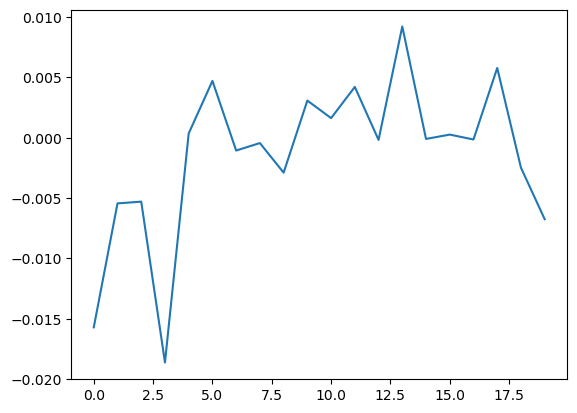

In [23]:
i = 0
j = 1
y = data_unweighted['overlap'][:,i,j]
plt.plot(y)